# Antarctic Intermediate Water (AAIW)

## Purpose:
Compute and plot the buoyancy contribution to potential vorticity over the Pacific Sector of the Southern Ocean.

## Acknowledgment:
This notebook builds on work by John Krasting (NOAA/GFDL). The original version can be found at:
https://github.com/jkrasting/mar/blob/main/src/gfdlnb/notebooks/ocean/AAIW_PV.ipynb.

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import numpy as np
import xarray as xr
import momlevel as ml
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import add_global_attrs 
from mom6_tools.m6toolbox import cime_xmlquery
from mom6_tools.m6toolbox import weighted_temporal_mean_vars
from mom6_tools.m6toolbox import geoslice
from mom6_tools.aaiw_pv import plot_aaiw_pv, plot_aaiw_pv_obs
import matplotlib.pyplot as plt
import yaml, os, intake

In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [4]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')

print('Output directory is:', OUTDIR)
print('Casename is:', casename)

Output directory is: /glade/derecho/scratch/gmarques/archive/g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079/ocn/hist/
Casename is: g.e30_a03c.GJRAv4.TL319_t232_wgx3_hycom1_N75.2024.079


In [40]:
# The following parameters must be set accordingly
######################################################
# add your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'
######################################################
# create an empty class object
class args:
  pass

# load avg dates
avg = diag_config_yml['Avg']

args.infile = OUTDIR
args.monthly = casename+diag_config_yml['Fnames']['z']
args.static = casename+diag_config_yml['Fnames']['static']
args.geom =   casename+diag_config_yml['Fnames']['geom']
args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = casename
args.label = diag_config_yml['Case']['SNAME']
args.savefigs = False
args.outdir = 'PNG/AAIW_PV/'

In [6]:
# read grid info
geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file, xrformat=True)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static, xrformat=True)

try:
  depth = grd.depth_ocean
except:
  depth = grd.deptho

MOM6 grid successfully loaded... 



In [7]:
# Coriolis
coriolis = ml.derived.calc_coriolis(grd.geolat)

In [8]:
cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.74:38827,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
def preprocess(ds):
    ''' Return a dataset desired variables'''
    variables = ['thetao', 'so', 'volcello']
    return ds[variables]

In [10]:
print('\n Reading dataset...')
# load data
%time ds = xr.open_mfdataset(OUTDIR+'/'+args.monthly, parallel=True, \
                             combine="nested", concat_dim="time", \
                             preprocess=preprocess).chunk({"time": 12})


 Reading dataset...
CPU times: user 3.53 s, sys: 405 ms, total: 3.93 s
Wall time: 45 s


In [11]:
print('\n Selecting data between {} and {}...'.format(args.start_date, args.end_date))
%time ds_sel = ds.sel(time=slice(args.start_date, args.end_date))


 Selecting data between 0031-01-01 and 0062-01-01...
CPU times: user 4.7 ms, sys: 95 μs, total: 4.8 ms
Wall time: 4.86 ms


In [12]:
attrs =  {
         'description': 'Annual mean thetao, so and volcello', 
         'reduction_method': 'annual mean weighted by days in each month',
         'casename': casename
         }

In [13]:
ds_ann = weighted_temporal_mean_vars(ds_sel, attrs=attrs)

In [14]:
ds_mean = ds_ann.mean("time")

In [15]:
zeta = 0.0
n2 = ml.derived.calc_n2(ds_mean.thetao, ds_mean.so)
pv = ml.derived.calc_pv(zeta, coriolis, n2, interp_n2=False, units="cm")
pv = pv.transpose("z_l", "yh", "xh")
pv = pv.load()

In [16]:
# Add the latitude and longitude as new coordinates to the pv DataArray
pv = pv.assign_coords({
    "latitude": (("yh", "xh"), grd.geolat.data),
    "longitude": (("yh", "xh"), grd.geolon.data)
})
#pv

In [17]:
ds_mean = ds_mean.assign_coords({
    "latitude": (("yh", "xh"), grd.geolat.data),
    "longitude": (("yh", "xh"), grd.geolon.data)
})
#ds_mean

In [18]:
levels, colors = ml.util.get_pv_colormap()

In [19]:
pv = geoslice(pv, x=(-180,-120),y=(-65,0), xcoord="longitude", ycoord="latitude")

In [20]:
yindex = pv.latitude.mean("xh")

### Calcualte the Volume

In [21]:
volcello = geoslice(ds_mean.volcello, x=(-180,-120),y=(-65,0), 
                             xcoord="longitude", ycoord="latitude")
volume = xr.where(pv > 60.0, volcello, np.nan).sel(z_l=slice(700, None)).sum()
volume = volume.load()
print(f"Volume of water with PV > 60 cm-2 s-1: {float(volume/1.0e15)} x 1.0e^15")

Volume of water with PV > 60 cm-2 s-1: 7.802598416942562 x 1.0e^15


### Make zonal mean plot

In [22]:
# Take the zonal mean
pv = pv.weighted(grd.areacello.fillna(0)).mean("xh")

In [23]:
pv = pv.transpose("z_l", "yh")

In [24]:
def plot_aaiw_pv(y, zl, pv, levels, colors, args):
    
  fig = plt.figure(figsize=(8, 4), dpi=100)
  ax = plt.subplot(1, 1, 1)
  cb = ax.contourf(y, zl, pv, levels=levels, colors=colors)
  cs = ax.contour(y, zl, pv, levels=levels, colors=["k"], linewidths=0.4)
  ax.set_ylim(0, 1800.0)
  ax.invert_yaxis()

  _ = ax.set_xlabel("Latitude [deegrees]\n(Averaged over 180W to 120W)")
  _ = ax.set_ylabel("Depth [m]")

  ax.hlines(
    700, y.min(), y.max(), colors="blue", linestyles="dashed", linewidths=0.7
  )

  ax.clabel(cs)

  _ = ax.text(
    0.0,
    1.06,
    r"Buoyancy Contribution to PV:  $(f * N^2)/g$",
    transform=ax.transAxes,
    fontsize=12,
    weight="bold",
  )

  _ = ax.text(
    0.0,
    1.015,
    args.label,
    transform=ax.transAxes,
    fontsize=10,
    style="italic",
  )

  plt.colorbar(cb, ticks=[5, 20, 60, 80, 100, 200], label=r"cm$^{-2}$ s$^{-1}$")
  if args.savefigs:
    fname = args.outdir + str(args.casename)+'_AAIW_PV.png'
    plt.savefig(fname, bbox_inches='tight')

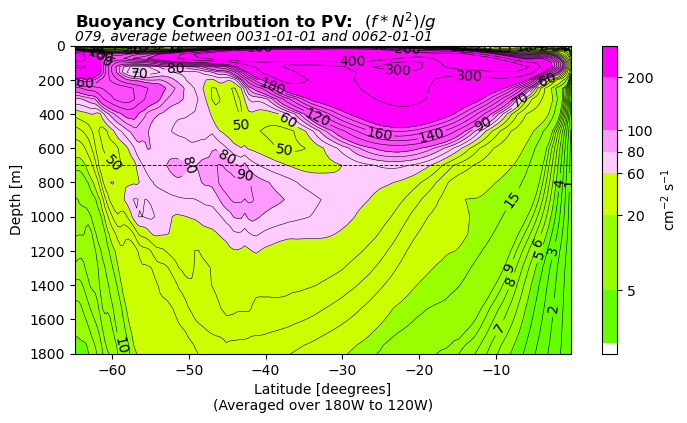

In [41]:
%matplotlib inline
args.label = args.label + ', average between ' + args.start_date + ' and ' + args.end_date
plot_aaiw_pv(yindex, pv.z_l, pv, levels, colors, args)

In [26]:
description = 'buoyancy contribution to potential vorticity over the Pacific Sector of the Southern Ocean'
attrs = {'description': description,
         'unit': 'cm2 s-1', 
         'start_date': args.start_date,
         'end_date': args.end_date}
add_global_attrs(pv,attrs)

In [27]:
print('Saving netCDF files...')
if not os.path.isdir('ncfiles'):
  os.system('mkdir ncfiles')
pv.to_netcdf('ncfiles/'+str(args.casename)+'_AAIW_PV.nc')

Saving netCDF files...


Volume of water with PV > 60 cm-2 s-1: 9.084359415955456 x 1.0e^15


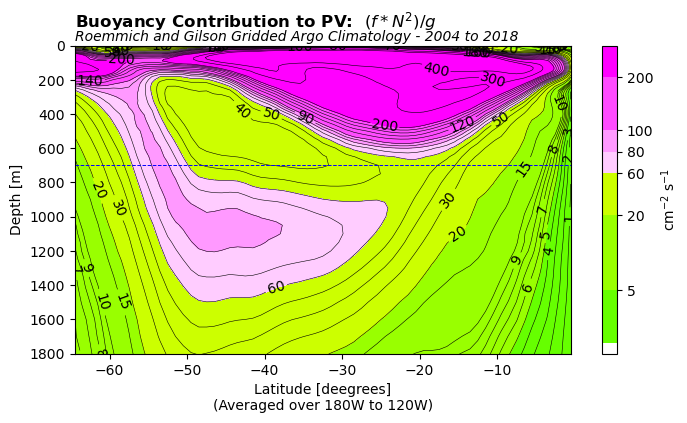

In [37]:
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
ds_obs = catalog['rg-argo-2018'].to_dask()
plot_aaiw_pv_obs(ds_obs, levels, colors)